In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=d1534a645b33ab966d30de990273cac15ca3f4864aa5ef88902664354ace97fe
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
train['defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train = train[['ImageId','ClassId','defect','EncodedPixels']]
train = train[train.defect]

In [ ]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [ ]:
train = pd.read_csv('/content/drive/My Drive/train.csv')
train['defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train = train[['ImageId','ClassId','defect','EncodedPixels']]
train = train[train.defect]
mask2rle(rle2mask_eda(train['EncodedPixels'].iloc[1]))==train['EncodedPixels'].iloc[1]


False

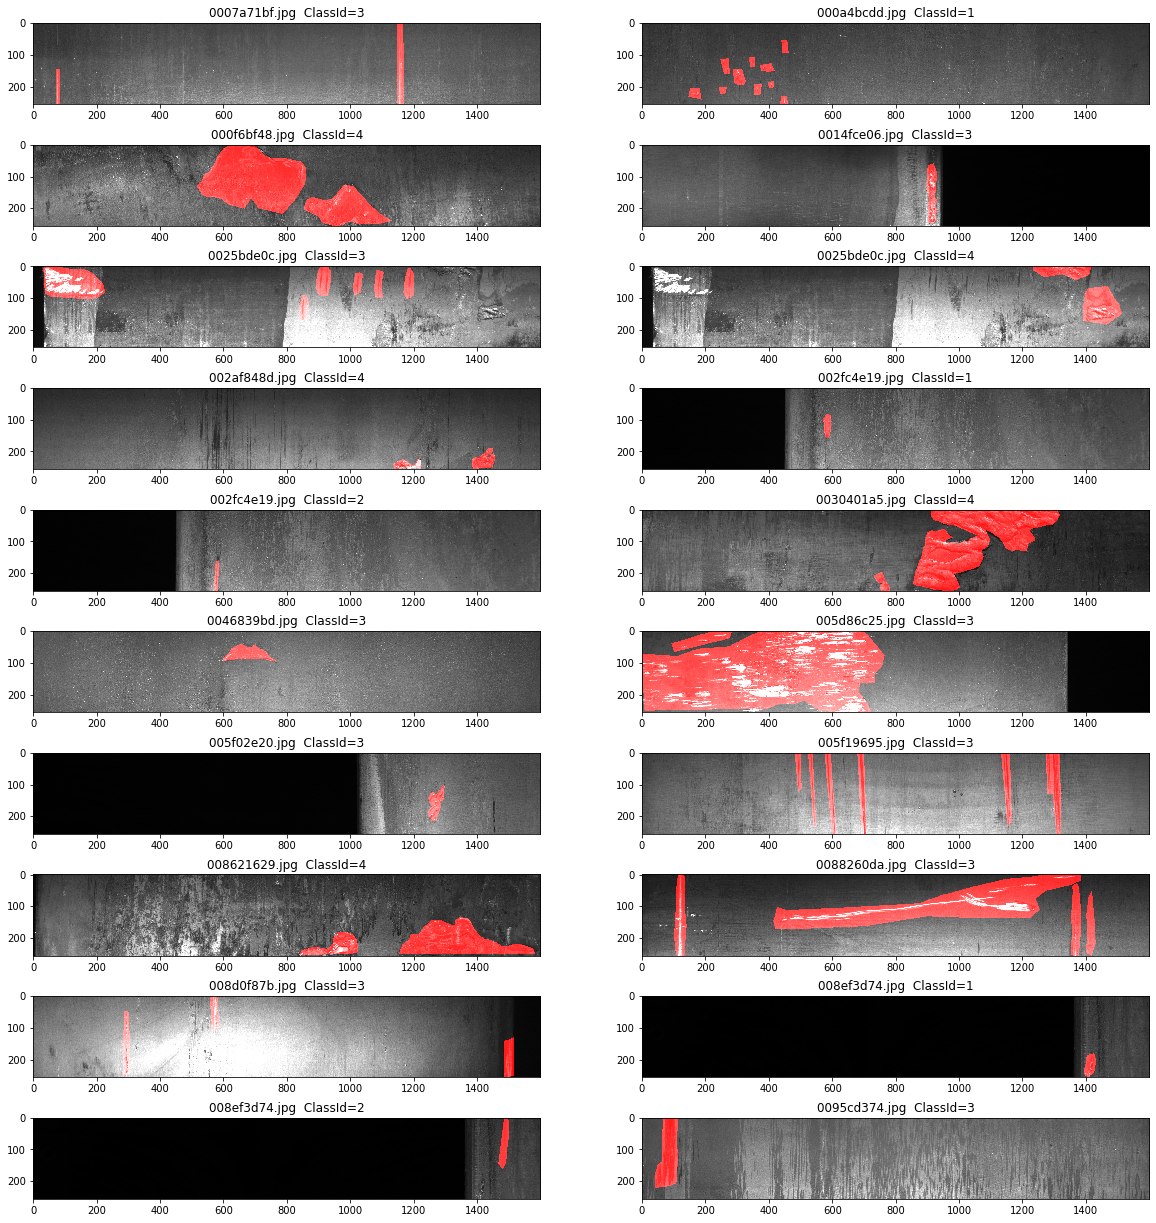

In [ ]:
#dontttt
columns = 2
rows = 10
fig = plt.figure(figsize=(20,columns*rows+2))
for i in range(1,columns*rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn+"  ClassId="+c)
    img = cv2.imread( '/content/drive/My Drive/Colab Notebooks/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask_eda(train['EncodedPixels'].iloc[i])
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/train.csv')
df_train = df_train[df_train['EncodedPixels'].notnull()].reset_index(drop=True)

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 4
EPOCHS = 20
PATIENCE = 7

In [ ]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread('/content/drive/My Drive/Colab Notebooks/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float64')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.8), 'float64')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.8], tf.float64)

In [ ]:
def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    return [ES, RR]

In [ ]:
base_model = Xception(weights=None, input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)
base_model.load_weights('/content/drive/My Drive/Colab Notebooks/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_out = base_model.output
up1 = UpSampling2D(32, interpolation='bilinear')(base_out)
conv1 = Conv2D(1, (1, 1))(up1)
conv1 = Activation('sigmoid')(conv1)
#bn1 = BatchNormalization()(conv1)
# re2 = LeakyReLU(0.2)(bn1)
# up2 = UpSampling2D(16, interpolation='bilinear')(re2)
# conv2 = Conv2D(1, (1, 1))(up2)
# conv2 = Activation('sigmoid')(conv2)

model = Model(base_model.input, conv1)
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [ ]:
history = model.fit_generator(keras_generator(BATCH_SIZE),
                              steps_per_epoch=len(df_train.index)/EPOCHS,                    
                              epochs=EPOCHS,                    
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
)



Epoch 1/20
355/354 [==============================] - 102s 287ms/step - loss: 0.3175 - iou_metric: 0.1692
Epoch 2/20
355/354 [==============================] - 87s 246ms/step - loss: 0.2789 - iou_metric: 0.1907
Epoch 3/20
355/354 [==============================] - 88s 247ms/step - loss: 0.2776 - iou_metric: 0.1946
Epoch 4/20
355/354 [==============================] - 87s 246ms/step - loss: 0.2769 - iou_metric: 0.1970
Epoch 5/20
355/354 [==============================] - 87s 246ms/step - loss: 0.2766 - iou_metric: 0.1974

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
355/354 [==============================] - 87s 246ms/step - loss: 0.2761 - iou_metric: 0.2000
Epoch 7/20
355/354 [==============================] - 87s 246ms/step - loss: 0.2760 - iou_metric: 0.2000
Epoch 8/20
355/354 [==============================] - 88s 247ms/step - loss: 0.2759 - iou_metric: 0.1994
Epoch 00008: early stopping


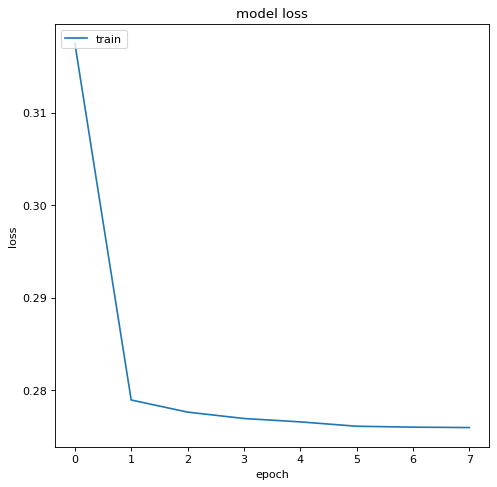

In [ ]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss']) 
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()

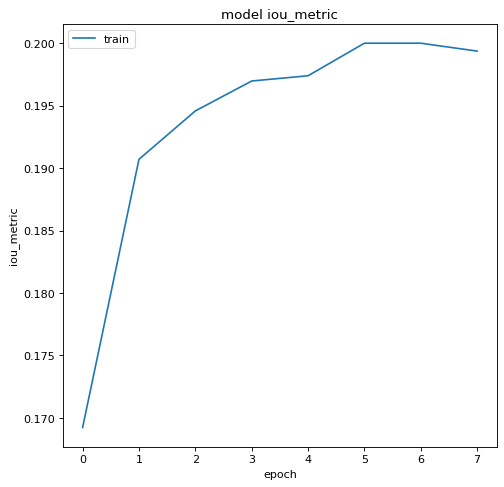

In [ ]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['iou_metric']) 
plt.title('model iou_metric')  
plt.ylabel('iou_metric')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()